In [2]:
# import pandas and matplotlib
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# import SQLalchemy create_engine, automap_base, session
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import distinct


In [4]:
import datetime as dt

# Hawaii trip period
* Start date - 2017/07/08
* End data - 2017/07/15

In [5]:
# create engine for the hawaii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# use inpector to explore database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# use inpector to print column names and types for measurement
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# refelct database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# start session to query the database
session = Session(engine)

In [10]:
# create variable to hold the query values for date and preciptation,
# last 12 months of data from the begining of my trip 2017/07/15

# convert date to %Y-%m-%d format
start= dt.date(2017, 7, 8)
end = dt.date(2017, 7, 15)

first_day = start.strftime('%Y-%m-%d')
last_day = end.strftime('%Y-%m-%d')

query_start = dt.date(2017, 7, 8) - dt.timedelta(365)
query_start_date = query_start.strftime('%Y-%m-%d')

query_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_start_date).\
    group_by(Measurement.date).all()
query_precipitation

[('2016-07-08', 0.31),
 ('2016-07-09', 0.15),
 ('2016-07-10', 1.15),
 ('2016-07-11', 0.11),
 ('2016-07-12', 0.03),
 ('2016-07-13', 0.14),
 ('2016-07-14', 1.15),
 ('2016-07-15', 1.7),
 ('2016-07-16', 2.05),
 ('2016-07-17', 0.55),
 ('2016-07-18', 0.23),
 ('2016-07-19', 0.41),
 ('2016-07-20', 0.08),
 ('2016-07-21', 0.01),
 ('2016-07-22', 0.13),
 ('2016-07-23', None),
 ('2016-07-24', 2.75),
 ('2016-07-25', 5.35),
 ('2016-07-26', 0.03),
 ('2016-07-27', 0.04),
 ('2016-07-28', 0.0),
 ('2016-07-29', 0.05),
 ('2016-07-30', 0.4),
 ('2016-07-31', 2.9),
 ('2016-08-01', 2.21),
 ('2016-08-02', 1.14),
 ('2016-08-03', None),
 ('2016-08-04', None),
 ('2016-08-05', None),
 ('2016-08-06', None),
 ('2016-08-07', 1.3),
 ('2016-08-08', 0.02),
 ('2016-08-09', 0.56),
 ('2016-08-10', 0.0),
 ('2016-08-11', 0.04),
 ('2016-08-12', 0.39),
 ('2016-08-13', 0.45),
 ('2016-08-14', 0.75),
 ('2016-08-15', 0.95),
 ('2016-08-16', 0.85),
 ('2016-08-17', 0.3),
 ('2016-08-18', 0.21),
 ('2016-08-19', 2.3),
 ('2016-08-20', 0.2

In [10]:
# load the results from the variable created into Pandas dataframe 
measurement_df = pd.DataFrame(query_precipitation)
# set index on date
measurement_df.set_index('date', inplace=True)
# sort values by date
measurement_df.sort_values(by='date')
# rename prcp to Precipitation for readability
measurement = measurement_df.rename(columns={"prcp":"Precipitation"})
# clean data by dropping any na value
measurement_results = measurement.dropna()
# now that the dataframe is sorted by date, reset index to use dates as a list to plot
measurement_reset_index = measurement_results.reset_index()

measurement_reset_index.head()

,date,Precipitation
0,2016-07-08,0.31
1,2016-07-09,0.15
2,2016-07-10,1.15
3,2016-07-11,0.11
4,2016-07-12,0.03


In [11]:
#unpack results into lists to plot
dates = [date for date in measurement_reset_index['date']]
precipitations = [precipitation for precipitation in measurement_reset_index['Precipitation']]

## Precipitation Analysis

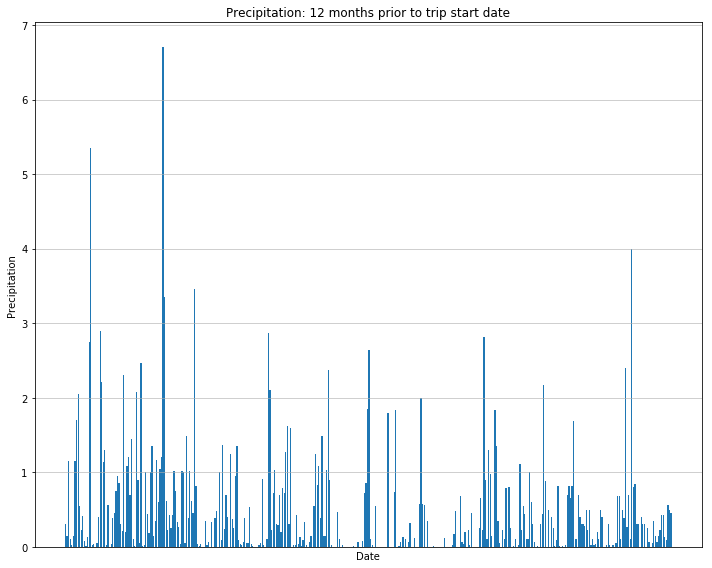

In [75]:
fig, ax =  plt.subplots(figsize=(10,8))
x_axis = np.arange(len(dates))
ax.bar(dates, precipitations)
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.yaxis.grid(alpha=0.75)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title("Precipitation: 12 months prior to trip start date")
plt.tight_layout()
plt.savefig("Resources/precipitaion.png")
plt.show()


In [13]:
measurement_reset_index.describe()

,Precipitation
count,386.000000
mean,0.473420
std,0.760321
min,0.000000
25%,0.010000
50%,0.190000
75%,0.640000
max,6.700000


## Station Analysis

In [14]:
# use inpector to print column names and types for station
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Number of statios available in the dataset

In [15]:
# counts the number os stations available in this dataset
query_stations = session.query(func.distinct(Measurement.station)).count()
print(query_stations)

9


#### Most active stations in descending order

In [16]:
# finds the most active stations in descending order
active_stations = session.query((Measurement.station),\
    func.count(Measurement.station).label("Station_Activity")).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

#### Most active station's lowest, highest and average temperatures

In [17]:
# most active station (USC00519281)lowest temperature, highest temperature and average temp
most_active_station = session.query(func.min(Measurement.tobs).label('lowest_temp'),\
                      func.max(Measurement.tobs).label('highest_temp'),\
                      func.avg(Measurement.tobs).label('average_temp')).\
                      filter(Measurement.station == "USC00519281").all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

##### 12 months tobs filtered by station with highest number of observations 

In [18]:
# find station with the highest number of temperarute observations
# filtering by the period 12 months before the end of the trip

tobs_last_12months = session.query(Measurement.station,\
    func.count(Measurement.tobs).label("Highest_number_observations")).\
    filter(Measurement.date > query_start_date).\
    filter(Measurement.date < last_day).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
tobs_last_12months

[('USC00513117', 371),
 ('USC00519281', 371),
 ('USC00519397', 369),
 ('USC00516128', 353),
 ('USC00519523', 345),
 ('USC00514830', 303),
 ('USC00517948', 200)]

 ###### Top Station tobs for the 12 months prior to the trip

In [19]:
# get all the data from the top station only
top_station_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_start_date).\
    filter(Measurement.date <= last_day).\
    filter(Measurement.station == 'USC00513117').all()

In [20]:
# put the date into a Pandas dataframe to plot the histogram
top_station_tobs_df = pd.DataFrame(top_station_tobs)
top_station_tobs_df.head()

,tobs
0,76.0
1,75.0
2,73.0
3,77.0
4,74.0


#### Histogram (Tobs for the  Top Station in the last 12 months)

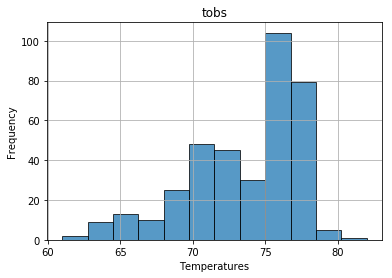

In [76]:
hist = top_station_tobs_df.hist(bins=12,edgecolor='black',alpha=0.75)

plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.savefig("Resources/histogram")
plt.show()

## Temperature Analysis

In [22]:
# Highest temperature, lowest temperature and average temperature 
#for the range of the trip duration

def calc_temps(start_date, end_date):
    
   
    sel = [Measurement.date,func.min(Measurement.tobs).label('min_temp'),\
           func.max(Measurement.tobs).label('max_temp'),\
           func.avg(Measurement.tobs).label('avg_temp')]
    
    return session.query(*sel).\
           filter(Measurement.date >= start_date).\
           filter(Measurement.date <= end_date).\
           group_by(Measurement.date).all()

calc_temps(first_day, last_day)

[('2017-07-08', 71.0, 81.0, 77.16666666666667),
 ('2017-07-09', 76.0, 82.0, 79.33333333333333),
 ('2017-07-10', 69.0, 82.0, 77.85714285714286),
 ('2017-07-11', 72.0, 81.0, 77.0),
 ('2017-07-12', 72.0, 82.0, 78.28571428571429),
 ('2017-07-13', 74.0, 81.0, 78.14285714285714),
 ('2017-07-14', 76.0, 81.0, 78.83333333333333),
 ('2017-07-15', 78.0, 82.0, 80.16666666666667)]

In [23]:
# previous year (2016) Highest temperature, lowest temperature and average temperature 
start= dt.date(2017, 7, 8)
end = dt.date(2017, 7, 15)

first_2016 = start - dt.timedelta(365)
last_2016 = end - dt.timedelta(365)

first_day_2016 = first_2016.strftime('%Y-%m-%d')
last_day_2016 = last_2016.strftime('%Y-%m-%d')

calc_temps(first_day_2016,last_day_2016)

[('2016-07-08', 73.0, 80.0, 77.85714285714286),
 ('2016-07-09', 71.0, 81.0, 77.66666666666667),
 ('2016-07-10', 72.0, 78.0, 76.0),
 ('2016-07-11', 72.0, 80.0, 76.0),
 ('2016-07-12', 75.0, 80.0, 78.85714285714286),
 ('2016-07-13', 74.0, 79.0, 76.66666666666667),
 ('2016-07-14', 73.0, 82.0, 78.14285714285714),
 ('2016-07-15', 71.0, 80.0, 76.71428571428571)]

### Plot Trip Average Temperature

In [24]:
previous_year_temps = pd.DataFrame(calc_temps(first_day_2016,last_day_2016))

results = []
for temp in previous_year_temps:
    diff = (previous_year_temps['max_temp'])-(previous_year_temps['min_temp'])
results.append(diff)

ptps = list(np.ravel(results))


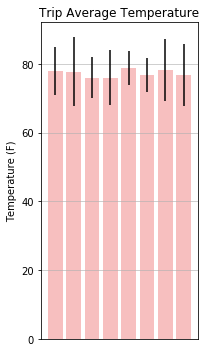

In [77]:
fig, ax = plt.subplots(figsize=(3, 5))

x = np.arange(len(previous_year_temps['avg_temp']))
ax.bar(x, previous_year_temps['avg_temp'], yerr=ptps, color='lightcoral', alpha=0.5)

ax.set_title('Trip Average Temperature')
ax.set_ylabel('Temperature (F)')

ax.yaxis.grid(alpha=0.75)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.savefig("Resources/trip_avg_temp.png")
plt.show()


### Rainfall per Weather Station

In [26]:
# should this be by total amount of rain or average of rain?


# joined both 
def rainfall_station(start_date, end_date):
    
    
    sel = [Stations.name, Stations.latitude, Stations.longitude, Stations.elevation,\
          func.avg(Measurement.prcp)]  
    
    return session.query(*sel).filter(Measurement.station == Stations.station).\
                      filter(Measurement.date >= start_date).\
                      filter(Measurement.date <= end_date).\
                      group_by(Measurement.station).\
                      order_by(func.avg(Measurement.prcp).desc()).all()
rainfall_station(first_day_2016, last_day_2016)
 

[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.5925),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.22999999999999998),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.145),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.1325),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13125),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.060000000000000005),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

### Daily Normals


In [27]:
# Create a query that will calculate the daily normals 

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs).label('min_temp'),\
           func.avg(Measurement.tobs).label('avg_temp'),\
           func.max(Measurement.tobs).label('max_temp')]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_normals= dt.date(2017, 7, 8)
end_normals = dt.date(2017, 7, 16) #had to add an extra day to show correct end date

# Use the start and end date to create a range of dates
range_dates = np.arange(start_normals, end_normals)
range_dates_dt= pd.to_datetime(range_dates)


# Strip off the year and save a list of %m-%d strings
month_days = range_dates_dt.strftime('%m-%d')


# Loop through the list of %m-%d strings and calculate the normals for each date
for date in month_days:
    normal = daily_normals(date)
    normals.append(normal)
print(normals)   

[[(69.0, 76.08333333333333, 83.0)], [(68.0, 76.19298245614036, 83.0)], [(68.0, 75.62068965517241, 82.0)], [(70.0, 75.78947368421052, 81.0)], [(67.0, 75.96491228070175, 82.0)], [(69.0, 76.1896551724138, 81.0)], [(61.0, 76.2280701754386, 82.0)], [(68.0, 76.2542372881356, 82.0)]]


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals)
normals_org = normals_df[0].apply(pd.Series)
normals_org['trip_dates'] = month_days
normals_renamed = normals_org.rename(columns={0:'Tmin',1:'Tavg',2:'Tmax'})
normals_renamed.set_index('trip_dates')


,Tmin,Tavg,Tmax
trip_dates,,,
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0
07-12,67.0,75.964912,82.0
07-13,69.0,76.189655,81.0
07-14,61.0,76.228070,82.0
07-15,68.0,76.254237,82.0


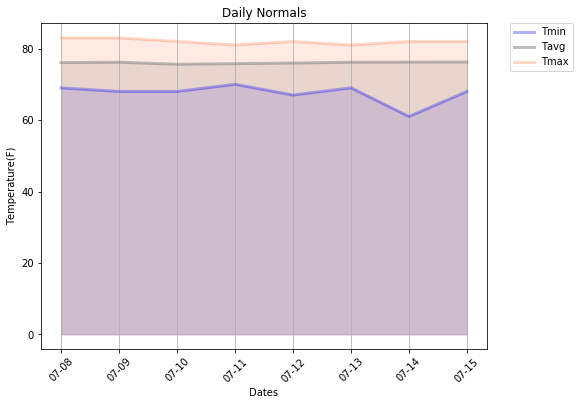

In [78]:
# Plot the daily normals as an area plot with `stacked=False`
tmin = normals_renamed['Tmin']
tavg = normals_renamed['Tavg']
tmax = normals_renamed['Tmax']
x_axis = np.arange(len(normals_renamed['trip_dates']))

# make the area plot 
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tmin, label='Tmin',linewidth=3,color='blue',alpha=0.3 )
ax.plot(tavg, label='Tavg',linewidth=3,color='grey',alpha=0.5)
ax.plot(tmax, label='Tmax',linewidth=3,color='coral',alpha=0.3)
# add fill to plot
ax.fill_between(np.arange(len(tmin)), tmin, color='blue', alpha=0.15)
ax.fill_between(np.arange(len(tavg)), tavg, color='grey', alpha=0.2)
ax.fill_between(np.arange(len(tmax)), tmax, color='coral', alpha=0.15)

ax.xaxis.set_ticks(np.arange(len(normals_renamed['trip_dates'])))
ax.set_xticklabels(normals_renamed['trip_dates'],rotation=45)

ax.xaxis.grid(alpha=1)

plt.title("Daily Normals")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Resources/daily_normals")
plt.show()


